In [81]:
rm(list = ls())
library(data.table)
library(ggplot2)

In [82]:
readCovfile <- function(fname, biotype) {
    dt = fread(fname)
    setnames(dt,"# chrom", "chrom")
    dt = dt[,
            .(chrom,
              chromStart,
              chromEnd,
              txLength = F7,
              geneName = F10,
              txType = F6,
              geneID = F11,
              txID = F3,
              readCount,
              sampleName,
              meanCoverage)]

    setnames(dt, "readCount", paste0("readCnt", biotype))
    setnames(dt, "sampleName", paste0(biotype, "ID"))
    setnames(dt, "meanCoverage", paste0("meanCov", biotype))
    
    return(dt)
}

getCanonical <- function(dt) {
    dt = dt[,
            .(chrom,
            txStart=chromStart[1],
            txEnd=chromEnd[length(chromEnd)],
            txLength,
            geneName,
            txType),
            by=.(geneID,txID)]

    dt = dt[txType=="protein_coding",
            .(txID,
              chrom,
              txStart,
              txEnd,
              txLength,
              geneName,
              txType,
              maxLength=max(txLength)),
              by=.(geneID)
           ][txLength==maxLength][,!c("maxLength")]

    dt = unique(dt)
    
    return(dt)
}

txPlot <- function(dt, ttl ,y1 = NA, xlab = "chr", ylab = "readcount ratio") {
    plot(NULL,
         ylab = ylab,
         xlab = xlab,
         type = "n",
         xlim = c(min(dt$x0), max(dt$x1)),
         ylim = c(0,max(c(dt$y1, y1), na.rm = T)),
         axes = F)
    
    axis(1)
    axis(2)
    
    N = nrow(dt)
    segments(x0 = dt$x0[1], y0 = 0,
             x1 = dt$x1[N], y1 = 0,
             lwd = 1, lty = 1, col = "blue",
             xlab = xlab)
    
    for (r in seq(N)) {
        segments(x0 = dt$x0[r], y0 = dt$y0[r],
                 x1 = dt$x1[r], y1 = dt$y1[r],
                 lwd = 2, col = "red")

        segments(x0 = dt$x0[r], y0 = 0,
                 x1 = dt$x1[r], y1 = 0,
                 lwd = 3, lty = 1)
    }
    
    title(ttl)
}

changeReadCnt <- function(L) {
    L[is.infinite(L)] = NaN
    return(L)
}

filterSampleCoverage <- function(sampCov, canonicalDT) {
    dt = sampCov[txID %in% canonicalDT$txID]

    #Add 1 to all reads to avoid having zero divisions. Instead filter based on total read count
    dt = dt[,
            .(readCntRatio = readCnttumor/(readCntnormal+1), readCnttumor, readCntnormal),
            by=.(chrom, chromStart, chromEnd, txID, geneName)]

    dt = unique(dt[,.(chrom,
                      chromStart,
                      chromEnd,
                      readCnttumor = sum(readCnttumor),
                      readCntnormal = sum(readCntnormal),
                      readCntRatio,
                      ExonCnt=.N, ZeroExon = sum(readCnttumor==0)),
                   by = .(txID, geneName)]
               )[ZeroExon < (ExonCnt/2) & (readCnttumor/ExonCnt) > 100,
                 .(chrom, chromStart, chromEnd,
                   readCnttumor, readCntnormal, readCntRatio,
                   ExonCnt, ZeroExon),
                 by = .(txID, geneName)]
    
    return(dt)
}

In [83]:
sample.coverage.tumor = readCovfile(fname = "notebook_data//ACC4817A3_R.sorted.mrkdup.exon.cov.bed",
                                    biotype = "tumor")

sample.coverage.normal = readCovfile(fname = "notebook_data//ACC4817A1_R.sorted.mrkdup.exon.cov.bed",
                                    biotype = "normal")

sample.coverage = merge(sample.coverage.tumor, sample.coverage.normal)

# TODO: get average per chromosome for canonical transcripts, cutoff for reads: 10
# TODO: get average per sample for canonical transcripts, cutoff for reads: 10
#
genename = "TP53,ERBB2,BRCA1,PHOSPHO1,CDK12"; ensemble = NULL; txname = NULL; chr = NULL; txwindow = NULL

allCanonical = getCanonical(sample.coverage.tumor)
allCanonical.normal = getCanonical(sample.coverage.normal)

if (! is.null(genename)) {
    genelist = unlist(strsplit(genename, ","))
    txlist = allCanonical[geneName %in% genelist]$txID
    txlist.input = txlist
} else if (! is.null(txname)) {
    txlist = unlist(strsplit(txname, ","))
    txlist.input = txlist
} else if (! is.null(ensemble)) {
    enslist = unlist(strsplit(ensemble, ","))
    txlist = allCanonical[geneID %in% enslist]$txID
    txlist.input = txlist
} else if (! is.null(chr)){
    txlist = allCanonical[chrom==chr]$txID
} else {
    stop("No input gene, ensemble, or transcript.")
}

if (! is.null(txwindow) && is.null(chr)) {
    txlist.region = allCanonical[txID %in% txlist,.(txID,
                                                    chrom,
                                                    txRegionStart = txStart - txwindow,
                                                    txRegionEnd = txEnd + txwindow)]
    
    plot_dt = allCanonical[0,]

    for (t in txlist) {
        plot_dt = funion(plot_dt, allCanonical[txStart >= txlist.region[txID==t]$txRegionStart &
                                               txEnd <= txlist.region[txID==t]$txRegionEnd &
                                               chrom == txlist.region[txID==t]$chrom])
    }
    
    txlist = plot_dt$txID
}

#dt.rgplot = sample.coverage[txID %in% txlist]
#
#dt.rgplot = dt.rgplot[,
#                      .(readCntRatio = readCnttumor/readCntnormal, readCnttumor, readCntnormal),
#                      by=.(chrom, chromStart, chromEnd, txID, geneName)]
#
#dt.rgplot = dt.rgplot[,.(chrom, chromStart, chromEnd, txID, geneName,
#                         readCntRatio = changeReadCnt(readCntRatio), readCnttumor, readCntnormal)]
#
#plot(dt.rgplot$readCntRatio, pch = 20, cex = 0.4, ylim = c(0,max(dt.rgplot$readCntRatio, na.rm = TRUE)))

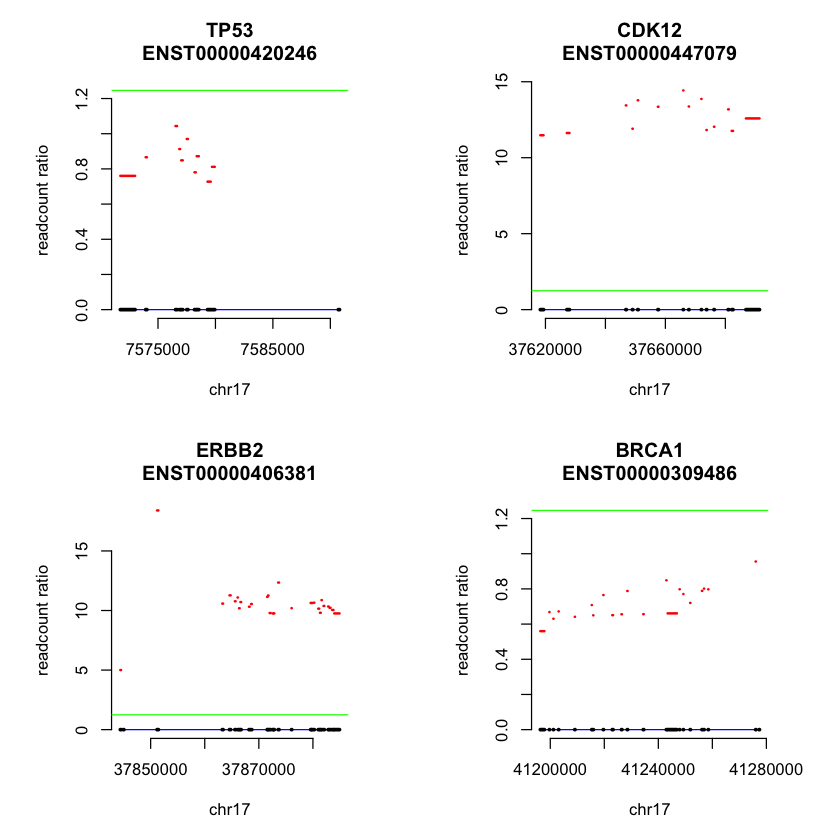

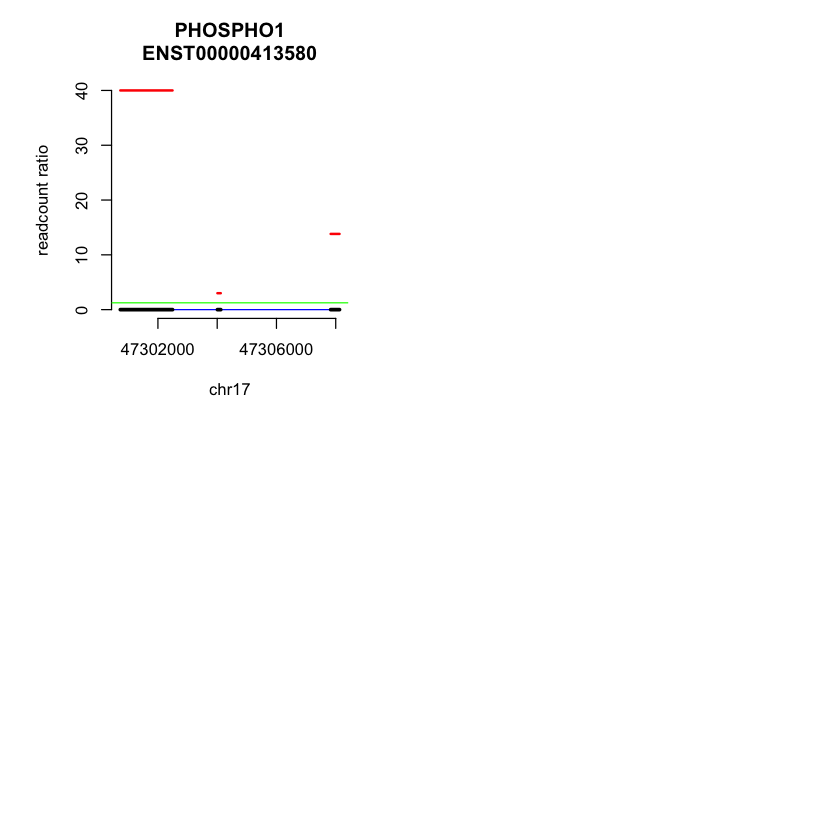

In [84]:
par(mfrow = c(2,2), pty = "s")

readcnt = filterSampleCoverage(sample.coverage, allCanonical)

dt.rgplot = readcnt[txID %in% txlist]

readcnt.chrom = unique(readcnt[,.(chrAVGreadCnt = median(readCntRatio, na.rm = T)), by = .(chrom)])
readcnt.genome = unique(readcnt[,.(genomeAVGreadCnt = median(readCntRatio, na.rm = T))])

for (t in txlist.input) {
    chr = unique(dt.rgplot[txID==t]$chrom)
    
    txPlot(dt.rgplot[txID==t,
                     .(x0=chromStart, x1=chromEnd, y0=readCntRatio, y1=readCntRatio)],
           ttl = paste0(unique(dt.rgplot[txID==t]$geneName), "\n", t),
           y1 = max(c(readcnt.chrom[chrom==chr]$chrAVGreadCnt, readcnt.genome$genomeAVGreadCnt )),
           xlab = paste0("chr",chr), ylab = "readcount ratio")
    
    abline(h=readcnt.chrom[chrom==chr]$chrAVGreadCnt, col = "green")
}

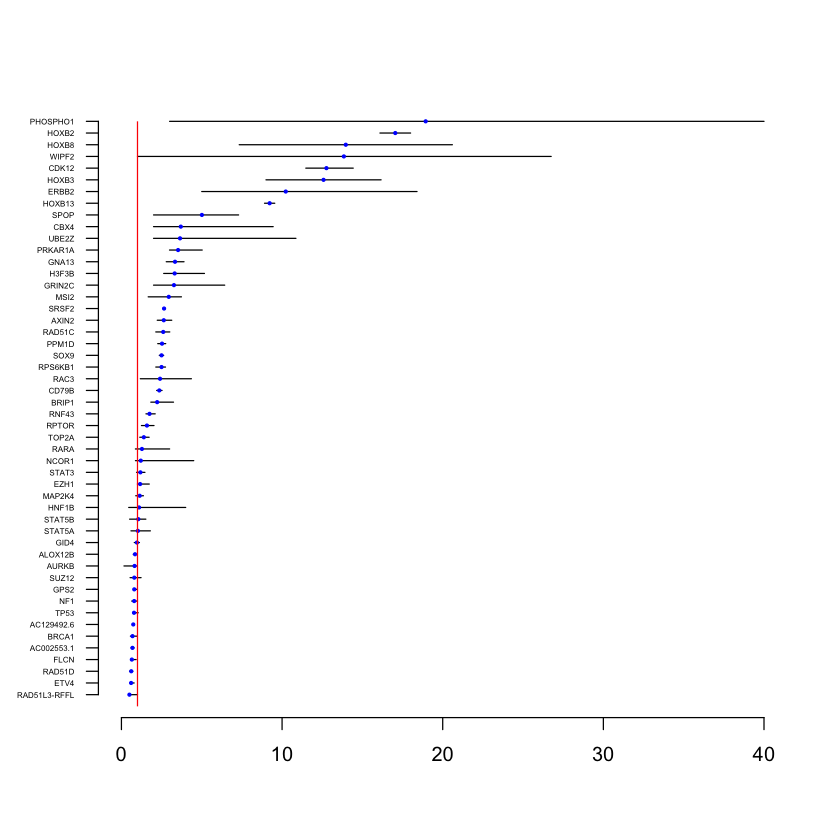

In [85]:
chr = unique(dt.rgplot$chrom)

dt = filterSampleCoverage(sample.coverage, allCanonical)

mytxID = dt[chrom %in% chr]$txID

dt = dt[txID %in% mytxID]

dt = unique(dt[txID %in% mytxID,
               .(geneName,
                 chrom,
                 SD=sd(readCntRatio, na.rm=TRUE),
                 AVG=mean(readCntRatio, na.rm=TRUE),
                 readCnttumor = sum(readCnttumor),
                 minRCratio = min(readCntRatio[readCntRatio>0], na.rm = T),
                 maxRCratio = max(readCntRatio, na.rm = T),
                 readCntnormal = sum(readCntnormal)
                ),
               by = .(chrom,txID)])[order(AVG, decreasing = F)]

dt = dt[,.(txID,geneName, SD, AVG, x0 = minRCratio, x1 = maxRCratio, index=.I, readCntnormal, readCnttumor)]
dt[,"color":="black"]
dt[geneName %in% c("TP53", "ERBB2"), "color":="red"]
#pdf("tmp.pdf", width = 7, height = 7, pointsize = 12)

plot.new()
plot.window(xlim = c(min(dt$x0, na.rm = TRUE),
                     max(dt$x1, na.rm = TRUE)),
            ylim = c(1,max(dt$index)))

N = nrow(dt)

axis(1)

ticks<-dt$index
axis(2,at=ticks, labels=dt$geneName, las = 1, cex.axis = 0.4, col = dt$color)

for (r in seq(N)) {
    segments(x0 = dt$x0[r], y0 = dt$index[r], x1 = dt$x1[r], y1 = dt$index[r])
}

points(x = dt$AVG, y = dt$index, cex = 0.5, col = "blue", pch = 20)
clip(0, 2, 0, max(dt$index))
abline(v=1, col = "red")
#garbage <- dev.off()

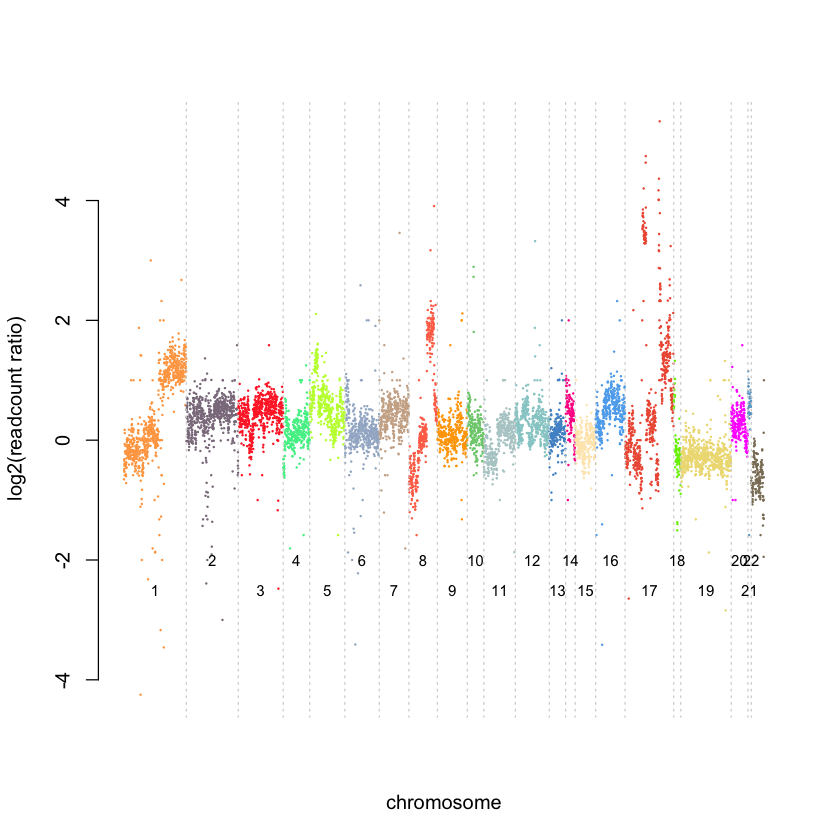

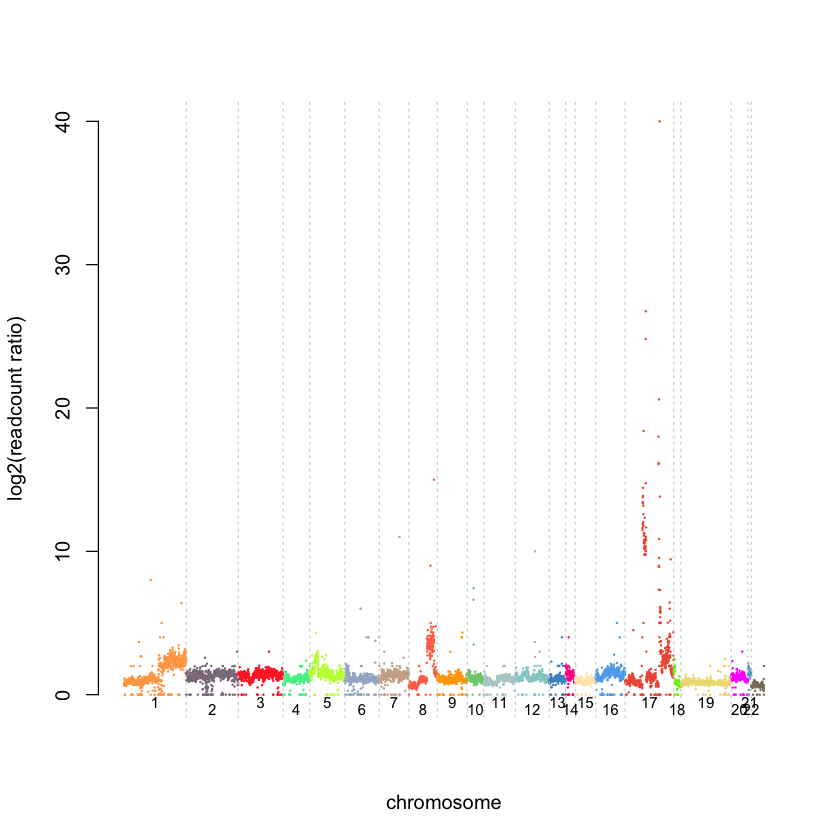

In [86]:
readcnt = filterSampleCoverage(sample.coverage, allCanonical)
readcnt = readcnt[order(chrom, chromStart, decreasing = F)]


color = grDevices::colors()[grep('gr(a|e)y', grDevices::colors(), invert = T)]
set.seed(42)
col = sample(color, 22)


col = unlist(lapply(col, function(x) {return(rep(x,times=sum(readcnt$chrom==unique(which(col==x)))))}))

plot(log2(readcnt$readCntRatio), pch = 20, cex = 0.2, axes = F, col = col,
     xlab = "chromosome", ylab = "log2(readcount ratio)")

axis(2)
chr = readcnt$chrom
ticks = which((chr - c(chr[1],chr[1:(length(chr)-1)])) == 1)

abline(v = ticks, col = "lightgray", lty = 3)

ticks = c(0, ticks)
ticks = c(sapply(seq(from=1, to=length(ticks)-1), function(x) {mean(c(ticks[x], ticks[x+1]))}),
          ticks[length(ticks)])

evenidx = which(seq(length(ticks))%% 2 == 0)
oddidx = which(!seq(length(ticks))%% 2 == 0)

text(x = ticks[evenidx], y = -2, labels = seq(22)[evenidx], cex = 0.75)
text(x = ticks[oddidx],  y = -2.5, labels = seq(22)[oddidx], cex = 0.75)

plot((readcnt$readCntRatio), pch = 20, cex = 0.2, axes = F, col = col,
     xlab = "chromosome", ylab = "log2(readcount ratio)")

axis(2)
chr = readcnt$chrom
ticks = which((chr - c(chr[1],chr[1:(length(chr)-1)])) == 1)

abline(v = ticks, col = "lightgray", lty = 3)

ticks = c(0, ticks)
ticks = c(sapply(seq(from=1, to=length(ticks)-1), function(x) {mean(c(ticks[x], ticks[x+1]))}),
          ticks[length(ticks)])

evenidx = which(seq(length(ticks))%% 2 == 0)
oddidx = which(!seq(length(ticks))%% 2 == 0)

text(x = ticks[evenidx], y = -1, labels = seq(22)[evenidx], cex = 0.75)
text(x = ticks[oddidx],  y = -0.5, labels = seq(22)[oddidx], cex = 0.75)

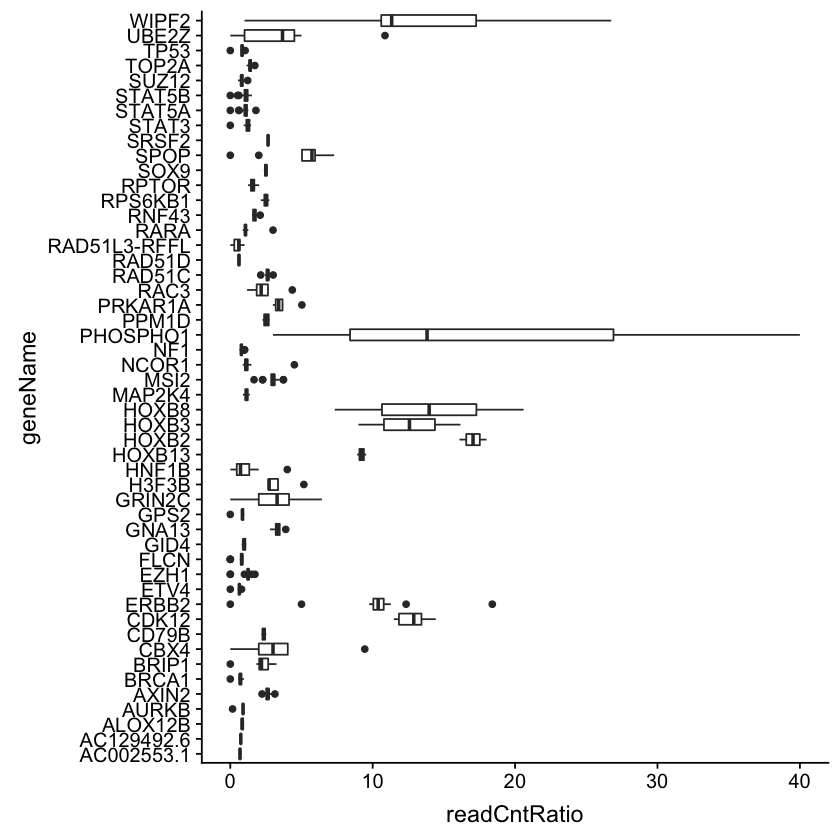

In [894]:
ggplot(as.data.frame(tmpdt[,.(geneName, readCntRatio)]),
       aes(reorder(geneName, readCntRatio, median, order = TRUE), 
           x = geneName, y = readCntRatio,
          )
      ) + 
    geom_boxplot() + coord_flip()

In [ ]:
rm(list = ls())

In [225]:
library(data.table)
library(cowplot)
library(ggplot2)
library(stargazer)

In [231]:
plotVarTable <- function(fname, i) {
    sample.coverage = fread(fname)
    sample.coverage[,ID:=paste0(CHROM,"_",POS,"_",REF,"_",ALT)]
    sample.coverage[,AF:=TUMOR_AD_ALT/(TUMOR_AD_REF+TUMOR_AD_ALT)]
    sample.coverage[,DP:=TUMOR_AD_REF+TUMOR_AD_ALT]
    dt = unique(sample.coverage[,.(ID,CALLER,AF,DP,TUMOR_AD_ALT)])

    p_af = ggplot(dt, aes(CALLER,AF)) + geom_boxplot() + 
        xlab("") + ylab("Allelic fraction") +
        theme_bw() + ggtitle(i)

    p_dp = ggplot(dt, aes(CALLER,DP)) + geom_boxplot() +
        xlab("") + ylab("Total read depth") +
        theme_bw()

    p_tad = ggplot(dt, aes(CALLER,TUMOR_AD_ALT)) + geom_boxplot() + theme_bw()

    p_af_dp = ggplot(dt, aes(x = DP, y = AF, group = CALLER, colour = CALLER)) +
        geom_point(size = 0.2) +
        theme_bw() +
        xlab("Total read depth") + ylab("Allelic fraction") +
        theme(legend.position = c(0.7, 0.5))

    p_af_tad = ggplot(dt, aes(x = TUMOR_AD_ALT, y = AF, group = CALLER, colour = CALLER)) +
        geom_point(size = 0.2) + ggtitle("alt allele depth < 25") +
        theme_bw() +
        xlab("Alt allele read depth") + ylab("Allelic fraction") +
        theme(legend.position = c(0.7, 0.5))

    plot_grid(p_af, p_dp, p_af_dp, p_af_tad, labels = 'AUTO', align = 'h', ncol = 2, nrow = 2)
    #rm(c("sample.coverage", "df", "i", "p_af", "p_dp", "p_tad", "p_af_dp", "p_af_tad"))
}

In [232]:
f = c("ACC4806A5_ACC4806A6",
      "ACC4806A5_ACC4806A7",
      "ACC4806A5_ACC4806A8",
      "ACC4806A6_ACC4806A7",
      "ACC4806A6_ACC4806A8",
      "ACC4806A7_ACC4806A8")
for (i in f) {
    fname = paste0("../notebook/notebook_data/",i,".vep_SNV.merged.table")
    cat(fname, " ")
    cat(nrow(fread(fname)), "\n")
#    print(plotVarTable(fname, i))
}

../notebook/notebook_data/ACC4806A5_ACC4806A6.vep_SNV.merged.table  8393 
../notebook/notebook_data/ACC4806A5_ACC4806A7.vep_SNV.merged.table  10934 
../notebook/notebook_data/ACC4806A5_ACC4806A8.vep_SNV.merged.table  10331 
../notebook/notebook_data/ACC4806A6_ACC4806A7.vep_SNV.merged.table  10860 
../notebook/notebook_data/ACC4806A6_ACC4806A8.vep_SNV.merged.table  11078 
../notebook/notebook_data/ACC4806A7_ACC4806A8.vep_SNV.merged.table  10087 


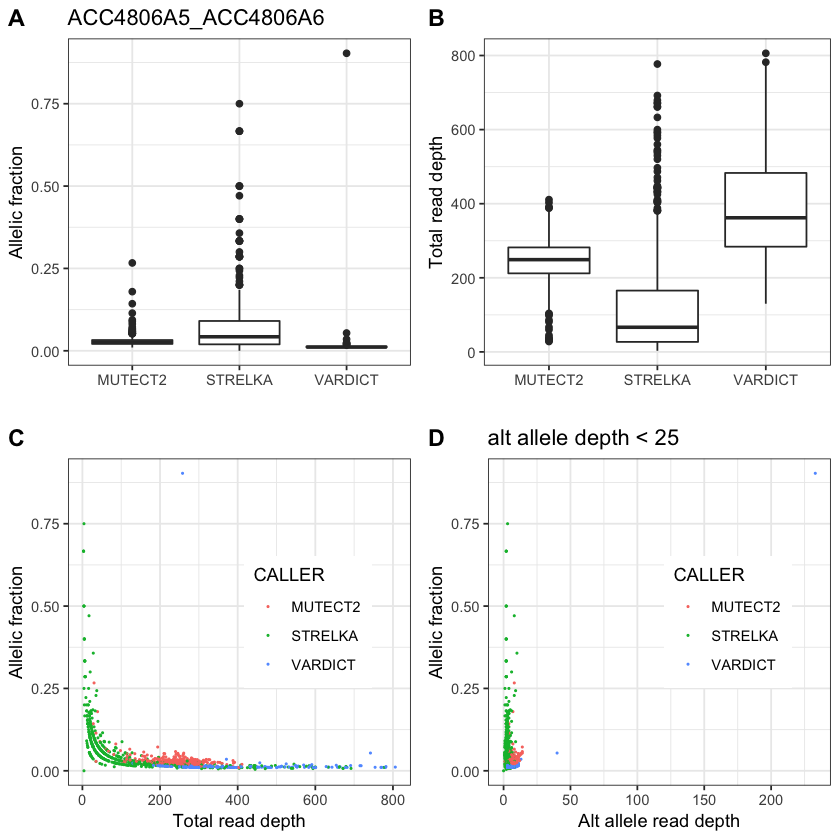

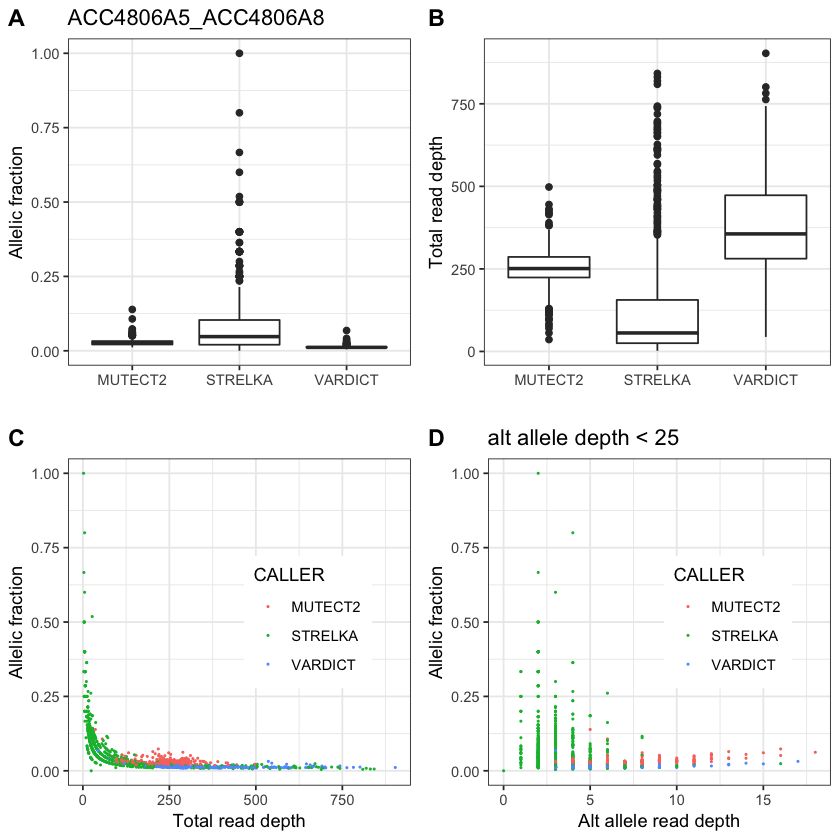

In [237]:
f = "ACC4806A5_ACC4806A6"
fname = paste0("../notebook/notebook_data/",f,".vep_SNV.merged.table")
plotVarTable(fname, f)

f = "ACC4806A5_ACC4806A8"
fname = paste0("../notebook/notebook_data/",f,".vep_SNV.merged.table")
plotVarTable(fname, f)

In [79]:
sample.coverage = fread("notebook_data/ACC4693A2_ATCGATCG_L001-2_R.sorted.mrkdup.exon.cov.bed")
setnames(sample.coverage, "# chrom", "chr")
head(sample.coverage)

chr,chromStart,chromEnd,F3,F4,F5,F6,F7,F8,F9,F10,F11,readCount,meanCoverage,percentage50,percentage100,percentage150,percentage200,percentage250,sampleName
1,11868,12227,ENST00000456328,+,pseudogene,processed_transcript,1657,3,KNOWN,DDX11L1,ENSG00000223972,0,0,0,0,0,0,0,ACC4693A2_ATCGATCG_L001-2_R
1,11871,12227,ENST00000515242,+,pseudogene,transcribed_unprocessed_pseudogene,1653,3,KNOWN,DDX11L1,ENSG00000223972,0,0,0,0,0,0,0,ACC4693A2_ATCGATCG_L001-2_R
1,11873,12227,ENST00000518655,+,pseudogene,transcribed_unprocessed_pseudogene,1483,4,KNOWN,DDX11L1,ENSG00000223972,0,0,0,0,0,0,0,ACC4693A2_ATCGATCG_L001-2_R
1,12009,12057,ENST00000450305,+,pseudogene,transcribed_unprocessed_pseudogene,632,6,KNOWN,DDX11L1,ENSG00000223972,0,0,0,0,0,0,0,ACC4693A2_ATCGATCG_L001-2_R
1,12178,12227,ENST00000450305,+,pseudogene,transcribed_unprocessed_pseudogene,632,6,KNOWN,DDX11L1,ENSG00000223972,0,0,0,0,0,0,0,ACC4693A2_ATCGATCG_L001-2_R
1,12594,12721,ENST00000518655,+,pseudogene,transcribed_unprocessed_pseudogene,1483,4,KNOWN,DDX11L1,ENSG00000223972,0,0,0,0,0,0,0,ACC4693A2_ATCGATCG_L001-2_R


In [241]:
arg = c()
arg$afmax = '1;1;1'
arg$afmin = '0.01;0.01;0.01'
arg$vartype = 'SNP,INDEL,MNP,OTHER;SNP,INDEL,MNP,OTHER;SNP,INDEL,MNP,OTHER'
arg$varcaller =  'MUTECT2;MUTECT2;MUTECT2,VARDICT'
arg$name = 'set_1;set_2;set_3'
arg$num = 1
arg$infile = "notebook_data/vep_SNV.merged.table"
arg$mode = "MVL"
arg$inMVL = "T;F;T"
x = "missense_variant,nonsynonymous_variant,stop_gained,stop_lost,start_lost,splice_acceptor_variant,splice_donor_variant,splice_donor_5th_base_variant,splice_site_variant,splicing_variant"
arg$ann = 'missense_variant,nonsynonymous_variant,stop_gained,stop_lost,start_lost,splice_acceptor_variant,splice_donor_variant,splice_donor_5th_base_variant,splice_site_variant,splicing_variant,frameshift_variant,frameshift,non-frameshift;missense_variant,nonsynonymous_variant,stop_gained,stop_lost,start_lost,splice_acceptor_variant,splice_donor_variant,splice_donor_5th_base_variant,splice_site_variant,splicing_variant,frameshift_variant,frameshift,non-frameshift;missense_variant,nonsynonymous_variant,stop_gained,stop_lost,start_lost,splice_acceptor_variant,splice_donor_variant,splice_donor_5th_base_variant,splice_site_variant,splicing_variant,frameshift_variant,frameshift,non-frameshift'
arg$dp = '20;20;20'
arg$tumorad = '8;8;8'
arg$inExon = T#"T;T;T;T;T"
arg$inGene = T#"T;T;T;T;T"
arg$type = "text"
arg$exportGene = F
arg$exclusiveSets = T
arg$genomeSize = 38000000

#arg = c()
#arg$afmax = "0.05"
#arg$afmin = "0.01"
#arg$vartype = "SNP"
#arg$varcaller =  "MUTECT2,VARDICT,STRELKA"
#arg$name = "set4"
#arg$num = 1
#arg$infile = "notebook_data/vep_SNV.merged.table"
#arg$mode = "MVL"
#arg$inMVL = "F"
#x = "missense_variant,nonsynonymous_variant,stop_gained,stop_lost,start_lost,splice_acceptor_variant,splice_donor_variant,splice_donor_5th_base_variant,splice_site_variant,splicing_variant"
#arg$ann = x
#arg$dp = "20"
#arg$tumorad = "8"
#arg$inExon = "T"
#arg$inGene = "T"
#arg$type = "text"
#arg$exportGene = F
#arg$exclusiveSets = T

In [242]:
trimStr <- function(x) {
    if (nchar(x) > 10) {
        x = paste0(substring(x, 1, 3), "...", substring(x, nchar(x)-3, nchar(x)))
    }
    return(x)
}

In [243]:
ConcatVarCall <- function(x) {
    x = gsub("VARDICT","V",x)
    x = gsub("STRELKA","S",x)
    x = gsub("MUTECT2","M",x)
    return(x)
}

var_param = c("afmax","afmin","inMVL","dp","tumorad","name","varcaller","ann","vartype")

set_cnt = c()
for (v in var_param) {
    arg[[v]] = unlist(strsplit(arg[[v]], split = ';', fixed = TRUE))
    set_cnt = c(length(unlist(strsplit(arg[[v]], split=';', fixed = T))), set_cnt)
}

if (length(unique(set_cnt)) > 1) {
    stop("Number of sets is different among inputs.", call.=FALSE)
}

int_vars = c("afmax","afmin","dp","tumorad")
for (v in int_vars) {
    arg[[v]] = as.numeric(arg[[v]])
}

bool_vars = c("inMVL")
for (v in bool_vars) {
    arg[[v]] = as.logical(arg[[v]])
}
arg

$afmax
[1] 1 1 1

$afmin
[1] 0.01 0.01 0.01

$vartype
[1] "SNP,INDEL,MNP,OTHER" "SNP,INDEL,MNP,OTHER" "SNP,INDEL,MNP,OTHER"

$varcaller
[1] "MUTECT2"         "MUTECT2"         "MUTECT2,VARDICT"

$name
[1] "set_1" "set_2" "set_3"

$num
[1] 1

$infile
[1] "notebook_data/vep_SNV.merged.table"

$mode
[1] "MVL"

$inMVL
[1]  TRUE FALSE  TRUE

$ann
[1] "missense_variant,nonsynonymous_variant,stop_gained,stop_lost,start_lost,splice_acceptor_variant,splice_donor_variant,splice_donor_5th_base_variant,splice_site_variant,splicing_variant,frameshift_variant,frameshift,non-frameshift"
[2] "missense_variant,nonsynonymous_variant,stop_gained,stop_lost,start_lost,splice_acceptor_variant,splice_donor_variant,splice_donor_5th_base_variant,splice_site_variant,splicing_variant,frameshift_variant,frameshift,non-frameshift"
[3] "missense_variant,nonsynonymous_variant,stop_gained,stop_lost,start_lost,splice_acceptor_variant,splice_donor_variant,splice_donor_5th_base_variant,splice_site_variant,splicing_variant,frameshift_variant,frameshift,non-frameshift"

$dp
[1] 20 20 20

$tumorad
[1] 8 8 8

$inExon
[1] TRUE

$inGene
[1] TRUE

$type
[1] "text"

$exportGene
[1] FALSE

$exclusiveSets
[1] TRUE

$genomeSize
[1] 3.8e+07

In [433]:
fwrite(x = unique(sample.coverage[CALLER=="MUTECT2" & SYMBOL!=".",
                   .("Chr:Pos" = paste0(CHROM,":",POS),
                     "Ref/Alt" = paste0(unlist(lapply(FUN = trimStr, REF)),"/",unlist(lapply(FUN = trimStr, ALT))),
                     "Caller" = ConcatVarCall(paste(unique(c(CALLER)), collapse = "/")),
                     "CallerCount" = length(unique(c(CALLER))),
                     "DP (Ref/Alt)" = paste0(floor(mean(TUMOR_AD_REF + TUMOR_AD_ALT)),
                                             "(",
                                             paste0(floor(mean(TUMOR_AD_REF)),"/", floor(mean(TUMOR_AD_ALT))),
                                             ")"),
                     "AF" = mean(TUMOR_AD_ALT/(TUMOR_AD_REF + TUMOR_AD_ALT)),
                     "Consequence" = paste(unique(c(Consequence)), collapse = ", "),
                     "Protein" = paste(unlist(unique(HGVSp)), collapse=", "),
                     "Gene" = paste(unlist(unique(SYMBOL)), collapse=", ")
                    )
                   ,by=.(ID)]), file = "MUTECT2_ACC4817A1_ACC4817A3.csv")

fwrite(x = unique(sample.coverage[CALLER=="VARDICT" & SYMBOL!=".",
                   .("Chr:Pos" = paste0(CHROM,":",POS),
                     "Ref/Alt" = paste0(unlist(lapply(FUN = trimStr, REF)),"/",unlist(lapply(FUN = trimStr, ALT))),
                     "Caller" = ConcatVarCall(paste(unique(c(CALLER)), collapse = "/")),
                     "CallerCount" = length(unique(c(CALLER))),
                     "DP (Ref/Alt)" = paste0(floor(mean(TUMOR_AD_REF + TUMOR_AD_ALT)),
                                             "(",
                                             paste0(floor(mean(TUMOR_AD_REF)),"/", floor(mean(TUMOR_AD_ALT))),
                                             ")"),
                     "AF" = mean(TUMOR_AD_ALT/(TUMOR_AD_REF + TUMOR_AD_ALT)),
                     "Consequence" = paste(unique(c(Consequence)), collapse = ", "),
                     "Protein" = paste(unlist(unique(HGVSp)), collapse=", "),
                     "Gene" = paste(unlist(unique(SYMBOL)), collapse=", ")
                    )
                   ,by=.(ID)]), file = "VARDICT_ACC4817A1_ACC4817A3.csv")


fwrite(x = unique(sample.coverage[CALLER=="STRELKA" & SYMBOL!=".",
                   .("Chr:Pos" = paste0(CHROM,":",POS),
                     "Ref/Alt" = paste0(unlist(lapply(FUN = trimStr, REF)),"/",unlist(lapply(FUN = trimStr, ALT))),
                     "Caller" = ConcatVarCall(paste(unique(c(CALLER)), collapse = "/")),
                     "CallerCount" = length(unique(c(CALLER))),
                     "DP (Ref/Alt)" = paste0(floor(mean(TUMOR_AD_REF + TUMOR_AD_ALT)),
                                             "(",
                                             paste0(floor(mean(TUMOR_AD_REF)),"/", floor(mean(TUMOR_AD_ALT))),
                                             ")"),
                     "AF" = mean(TUMOR_AD_ALT/(TUMOR_AD_REF + TUMOR_AD_ALT)),
                     "Consequence" = paste(unique(c(Consequence)), collapse = ", "),
                     "Protein" = paste(unlist(unique(HGVSp)), collapse=", "),
                     "Gene" = paste(unlist(unique(SYMBOL)), collapse=", ")
                    )
                   ,by=.(ID)]), file = "STRELKA_ACC4817A1_ACC4817A3.csv")

In [259]:
sample.coverage[SYMBOL=="BRCA2"]

CHROM,POS,REF,ALT,TYPE,CALLER,TUMOR_DP,TUMOR_AD_REF,TUMOR_AD_ALT,FILTERED,⋯,MAX_AF_POPS,CLIN_SIG,SOMATIC,PHENO,PUBMED,MOTIF_NAME,MOTIF_POS,HIGH_INF_POS,MOTIF_SCORE_CHANGE,ID
13,32950804,T,A,SNP,STRELKA,987,965,21,YES,⋯,.,.,.,.,.,.,.,.,.,13_32950804_T_A
13,32950804,T,A,SNP,STRELKA,987,965,21,YES,⋯,.,.,.,.,.,.,.,.,.,13_32950804_T_A
13,32950804,T,A,SNP,STRELKA,987,965,21,YES,⋯,.,.,.,.,.,.,.,.,.,13_32950804_T_A
13,32950804,T,A,SNP,STRELKA,987,965,21,YES,⋯,.,.,.,.,.,.,.,.,.,13_32950804_T_A
13,32950804,T,A,SNP,STRELKA,987,965,21,YES,⋯,.,.,.,.,.,.,.,.,.,13_32950804_T_A
13,32950804,T,A,SNP,STRELKA,987,965,21,YES,⋯,.,.,.,.,.,.,.,.,.,13_32950804_T_A
13,32950804,T,A,SNP,STRELKA,987,965,21,YES,⋯,.,.,.,.,.,.,.,.,.,13_32950804_T_A
13,32950804,T,A,SNP,STRELKA,987,965,21,YES,⋯,.,.,.,.,.,.,.,.,.,13_32950804_T_A
13,32954327,A,G,SNP,STRELKA,431,417,12,YES,⋯,.,.,.,.,.,.,.,.,.,13_32954327_A_G
13,32954327,A,G,SNP,STRELKA,431,417,12,YES,⋯,.,.,.,.,.,.,.,.,.,13_32954327_A_G


In [407]:
sample.coverage = fread(arg$infile, showProgress=F)
sample.coverage[,ID:=paste0(CHROM,"_",POS,"_",REF,"_",ALT)]

dt_excl = data.table()

arg$mode = "TMB"

if (arg$mode == "MVL") {
    var_param = c("afmax","afmin","inMVL","dp","tumorad","name","varcaller","ann","vartype","outfile")


    for (i in 1:unique(set_cnt)) {
        mvl = arg$inMVL[i]
        if (mvl) {
          mvl = "1"
        } else {
          mvl = "."
        }
        dp = arg$dp[i]
        tumor_ad_alt = arg$tumorad[i]
        af_max = arg$afmax[i]
        af_min = arg$afmin[i]
        var_type = unlist(strsplit(arg$vartype[i], ","))
        var_caller = unlist(strsplit(arg$varcaller[i], ","))
        table_name = arg$name[i]
        table_num = arg$num[i]
        outfile = arg$outfile[i]

        var_caller = toupper(var_caller)
        if (any(var_caller %in% "ANY")) {
            var_caller = c("MUTECT2", "VARDICT", "STRELKA")
        }

        dt = sample.coverage[CALLER %in% var_caller
                             & MSK_MVL == mvl
                             & (TUMOR_AD_REF + TUMOR_AD_ALT) >= dp
                             & TUMOR_AD_ALT / (TUMOR_AD_REF + TUMOR_AD_ALT) <= af_max
                             & TUMOR_AD_ALT / (TUMOR_AD_REF + TUMOR_AD_ALT) >= af_min
                             & TUMOR_AD_ALT >= tumor_ad_alt
                             & TYPE %in% var_type]
        
        if (! is.null(arg$ann)) {
          var_ann = unlist(strsplit(arg$ann, ",")) 
          dt = dt[Consequence %in% var_ann]
        }

        if (arg$inExon) {
          dt = dt[EXON != "."]
        }

        if (arg$inGene) {
          dt = dt[SYMBOL != "."]
        }

        if (nrow(dt)!=0) {       

            dt = dt[,
                   .("Chr:Pos" = paste0(CHROM,":",POS),
                     "Ref/Alt" = paste0(unlist(lapply(FUN = trimStr, REF)),"/",unlist(lapply(FUN = trimStr, ALT))),
                     "Caller" = ConcatVarCall(paste(unique(c(CALLER)), collapse = "/")),
                     "CallerCount" = length(unique(c(CALLER))),
                     "DP (Ref/Alt)" = paste0(floor(mean(TUMOR_AD_REF + TUMOR_AD_ALT)),
                                             "(",
                                             paste0(floor(mean(TUMOR_AD_REF)),"/", floor(mean(TUMOR_AD_ALT))),
                                             ")"),
                     "AF" = mean(TUMOR_AD_ALT/(TUMOR_AD_REF + TUMOR_AD_ALT)),
                     "Consequence" = paste(unique(c(Consequence)), collapse = ", "),
                     "Protein"=paste(unlist(strsplit(HGVSp,":"))[2], collapse=", "),
                     "Gene" = SYMBOL
                    )
                   ,by=.(ID)]

            dt = unique(dt)
            dt = dt[,c("Chr:Pos", "Ref/Alt", "Caller", "DP (Ref/Alt)", "AF", "Gene", "Consequence", "Protein")]

            if (nrow(dt_excl)==0) {
                dt_excl = dt[0,]
            }
            
        }

            if (arg$exclusiveSets & unique(set_cnt) > 1 & nrow(dt)>0) {
            dt = fsetdiff(dt, dt_excl, all = FALSE)
            dt_excl = funion(dt, dt_excl)
        }

        if (nrow(dt)==0) {
            write(paste0("No variant were for found for table ", table_name), "")
            #write(" ", file = outfile)
        } else {
            if (arg$exportGene) {
                write(paste0("list of genes for table ", table_name, " : ",
                      paste(unlist(unique(dt[, c("Gene")])), collapse=",")), "")
                write(paste(unlist(unique(dt[, c("Gene")])), collapse=","), file = outfile)
            } else {
                if (is.null(arg$outfile) || arg$type == "text") {
                    stargazer(dt, summary = FALSE, type = arg$type, title = table_name,
                              table.placement = "H", digit.separator = "", rownames = F, style = "io", float = T,
                              notes = c(paste0("1. A summary of results based on \"",
                                               table_name, "\" specification."),
                                        paste0("2. Variant callers included: ",
                                               tolower(paste(var_caller, collapse = ", ")))),
                              header = F, out.header = F)
                } else {
                    stargazer(dt, summary = FALSE, title = table_name,
                              table.placement = "H", digit.separator = "", rownames = F, style = "io", float = T,
                              notes = c(paste0("1. A summary of results based on \"",
                                               table_name, "\" specification."),
                                        paste0("2. Variant callers included: ",
                                               tolower(paste(var_caller, collapse = ", ")))),
                              header = F, out.header = F, out = outfile)
                }
            }
        }
    }
} else if ( arg$mode == "TMB" ) {
  if (is.null(arg$genomeSize)) {
    stop("Genome/panel size is required.", call.=FALSE)
  }
  genomeLength = arg$genomeSize / 1e6

  var_caller = as.list(unique(sample.coverage[,"CALLER"]))$CALLER
  annotation = c("stop_gained", "stop_lost", "start_lost",
                 "missense_variant", "nonsynonymous_variant",
                 "splice_acceptor_variant", "splice_donor_variant",
                 "splice_donor_5th_base_variant", "splice_site_variant",
                 "splicing_variant", "frameshift_variant")

  dt1 = unique(sample.coverage[CALLER %in% var_caller
                       & Consequence %in% annotation, .(CHROM, POS),
                       by=.(ID, CALLER)])[,.(.N,"TMB"=.N/genomeLength),by=.(CALLER)]

  dt2 = unique(sample.coverage[CALLER %in% var_caller
                       & Consequence %in% annotation, .(CALLER),
                       by=.(ID)][,.(ID)])[,.(.N)]
  dt2[,"CALLER":="ALL"]
  setcolorder(dt2, neworder = c("CALLER", "N"))
  dt = dt2[,.(CALLER, N, "TMB"=N/genomeLength)]

  str_annot = paste(gsub("_", "-", annotation), collapse = ", ")
  dt.TMB = rbind(dt1, dt)
  stargazer(unique(dt.TMB), summary = FALSE, type = arg$type,
            title = "Tumor mutation burden (TMB)",
            digit.separator = "", rownames = F, style = "io",
            header = F, out.header = F, table.placement = "H", float = T#, 
#            notes = c(paste0("1. Variant callers included: ",
#                             tolower(paste(as.list(unique(sample.coverage[,"CALLER"]))$CALLER,
#                                           collapse = ", "))),
#                      paste0("2. Variant types: ",
#                             tolower(paste(as.list(unique(sample.coverage[,"VARIANT_CLASS"]))$VARIANT_CLASS,
#                                           collapse=", "))),
#                      paste0("3. Only all coding variants (all subchilds of nonsynonymous variants annotation)"))
           )

} else if ( arg$mode == "VarClass" ) {
  dt = unique(sample.coverage[,.(ID,CALLER,VARIANT_CLASS)])
  dt.typevars = dt[,.("CALLERCOUNT"=length(unique(c(CALLER))),.N),
                   by=.("CALLERS"=CALLER,VARIANT_CLASS)][order(CALLERS,-VARIANT_CLASS)]
  
  dt = unique(sample.coverage[,.(ID,CALLER,VARIANT_CLASS)])
  dt = dt[,.("CALLERS"="ALL","CALLERCOUNT"=length(unique(c(CALLER))),.N),
          by=(VARIANT_CLASS)]
  
  setcolorder(dt, neworder = c("CALLERS", "VARIANT_CLASS", "CALLERCOUNT","N"))
  dt.typecensus = rbind(dt, dt.typevars)
  
  dt = unique(sample.coverage[,.(ID,CALLER)])
  dt.allcallers = dt[,.("VARIANT_CLASS"="All_types","CALLERCOUNT"=1,.N), by=.("CALLERS"=CALLER) ][order(CALLERS)]
  
  dt.callercensus = rbind(dt.allcallers,dt.typecensus)[order(CALLERS,VARIANT_CLASS,CALLERCOUNT)]
  stargazer(unique(dt.callercensus), summary = FALSE, type = arg$type,
            title = "Variant class summary",
            digit.separator = "", rownames = F, style = "io",
            header = F, out.header = F, table.placement = "H", float = T, 
            notes = c(paste0("1. A summary of variant classes devided by variant class and variant caller"),
                      paste0("2. Variant callers included: ",
                             tolower(paste(as.list(unique(sample.coverage[,"CALLER"]))$CALLER,
                                           collapse = ", "))),
                      paste0("3. Variant types: ",
                             tolower(paste(as.list(unique(sample.coverage[,"VARIANT_CLASS"]))$VARIANT_CLASS,
                                           collapse=", ")))))
} else if ( arg$mode == "VarCaller" ) {
  
  var_caller = as.list(unique(sample.coverage[,"CALLER"]))$CALLER
  var_caller_combn = do.call("c", lapply(seq_along(var_caller),
                                         function(i) {combn(var_caller, i, simplify = F)}))

  dt = unique(sample.coverage[,.(ID,CALLER,VARIANT_CLASS)])
  dt = dt[,.("CALLERS"=paste(unique(c(CALLER)),collapse = "-"),
                          "CALLERCOUNT"=length(unique(c(CALLER)))),
                       by=.(ID)][,.(.N),
                                 by=.(CALLERS,CALLERCOUNT)
                                ]

  dt.venn = dt[order(CALLERCOUNT,CALLERS)]
  stargazer(unique(dt.venn), summary = FALSE, type = arg$type,
            title = "Variant caller summary",
            digit.separator = "", rownames = F, style = "io",
            header = F, out.header = F, table.placement = "H", float = T, 
            notes = c(paste0("1. A summary of exclusive variant types ",
                             "devided by variant callers that identified them"),
                      paste0("2. Variant callers included: ",
                             tolower(paste(as.list(unique(sample.coverage[,"CALLER"]))$CALLER,
                                           collapse = ", "))),
                      paste0("3. Variant types: ",
                             tolower(paste(as.list(unique(sample.coverage[,"VARIANT_CLASS"]))$VARIANT_CLASS,
                                           collapse=", ")))))
} else if ( arg$mode == "VarCallerClass" ){
  
  var_caller = as.list(unique(sample.coverage[,"CALLER"]))$CALLER
  var_caller_combn = do.call("c", lapply(seq_along(var_caller),
                                         function(i) {combn(var_caller, i, simplify = F)}))

  dt = unique(sample.coverage[,.(ID,CALLER,VARIANT_CLASS)])
  dt = dt[,.("CALLERS"=paste(unique(c(CALLER)),collapse = "-"),
                          "CALLERCOUNT"=length(unique(c(CALLER))),
                          VARIANT_CLASS),
                       by=.(ID)][,.(.N),
                                 by=.(CALLERS,VARIANT_CLASS,CALLERCOUNT)
                                ]

  dt.venn = dt[order(CALLERCOUNT,CALLERS,VARIANT_CLASS)]
  stargazer(unique(dt.venn), summary = FALSE, type = arg$type,
            title = "Variant caller summary by variant class",
            digit.separator = "", rownames = F, style = "io",
            header = F, out.header = F, table.placement = "H", float = T, 
            notes = c(paste0("1. A summary of exclusive variant types ",
                             "devided by variant callers that identified them"),
                      paste0("2. Variant callers included: ",
                             tolower(paste(as.list(unique(sample.coverage[,"CALLER"]))$CALLER,
                                           collapse = ", "))),
                      paste0("3. Variant types: ",
                             tolower(paste(as.list(unique(sample.coverage[,"VARIANT_CLASS"]))$VARIANT_CLASS,
                                           collapse=", "))))
           )
} else {
  stop("Run mode not recognized", call.=FALSE) 
}


Tumor mutation burden (TMB)
------------------
CALLER   N   TMB  
------------------
STRELKA 482 12.684
VARDICT 236 6.211 
MUTECT2 21  0.553 
ALL     648 17.053
------------------


In [246]:
head(dt)
head(dt_excl)

Chr:Pos,Ref/Alt,Caller,DP (Ref/Alt),AF,Gene,Consequence,Protein


Chr:Pos,Ref/Alt,Caller,DP (Ref/Alt),AF,Gene,Consequence,Protein
12:49424161,ACC...AGGG/CCC...AAGA,V,1439(1423/16),0.01111883,KMT2D,frameshift_variant,p.Pro4623SerfsTer23
17:7578263,G/A,V/M,978(94/884),0.90683374,TP53,stop_gained,p.Arg196Ter
17:37880261,G/T,V,13833(13397/436),0.03151883,ERBB2,missense_variant,p.Asp769Tyr
18:48593508,G/A,V,1173(1161/12),0.01023018,SMAD4,missense_variant,p.Arg420His
3:178952085,A/G,V,2078(1146/932),0.44850818,PIK3CA,missense_variant,p.His1047Arg
7:2968308,TGC...GGGG/T,V,2065(2044/21),0.01016949,CARD11,frameshift_variant,p.Pro24HisfsTer33


In [235]:
t.gene = sample.coverage[F11 %in% c("ENSG00000002016","ENSG00000012048", "ENSG00000272333", "ENSG00000245848") &
                          F9 == "KNOWN" & F6 == "protein_coding", 
                          .(exonCount = .N,
                            readPerbp = sum(readCount)/F7,
                            meanExonCoverage = mean(readCount/(abs(chromStart-chromEnd))),
                            readPerbpPerExon = sum(readCount)/(F7/.N),
                            totalRead = sum(readCount)),
                          by=.(F3, F7, F11, F10)][, .(txID = F3, txLength = F7, geneName = F10,
                                                      exonCount, readPerbp, readPerbpPerExon, totalRead,
                                                      maxLength = max(F7), maxRead = max(totalRead),
                                                      meanExonCoverage),
                                                  keyby=F11][txLength==maxLength, !c("maxLength")]
setnames(dt.gene, "F11", "geneID")
dt.gene

ERROR: Error in eval(expr, envir, enclos): object 'sample.coverage' not found


In [752]:
write(x = dt$Gene, sep = ",", "")

UBR4
ZBTB7B
ZBTB7B
TRIM46
PAPPA2
IGFN1
IGFN1
AHNAK2
AHNAK2
GOLGA8K
NPIPA1
ZNF595
MUC12
MUC12
MUC12
MUC12
SPATA31A6


In [300]:
stargazer(dt.gene, summary = FALSE, type = "text")


      geneID           txID       txLength geneName exonCount readPerbp readPerbpPerExon totalRead maxRead meanExonCoverage
---------------------------------------------------------------------------------------------------------------------------
1 ENSG00000002016 ENST00000358495  2,710    RAD52      12       9.015       108.186       24,432   24,432       16.341     
2 ENSG00000012048 ENST00000309486  7,114    BRCA1      22      11.540       253.891       82,099   84,801       18.437     
3 ENSG00000245848 ENST00000498907  2,631    CEBPA       1       4.006        4.006        10,540   10,540       4.006      
4 ENSG00000272333 ENST00000222270  8,469    KMT2B      37      16.290       602.730       137,960  137,960      20.436     
5 ENSG00000272333 ENST00000420124  8,469    KMT2B      37      16.288       602.656       137,943  137,960      20.423     
---------------------------------------------------------------------------------------------------------------------------


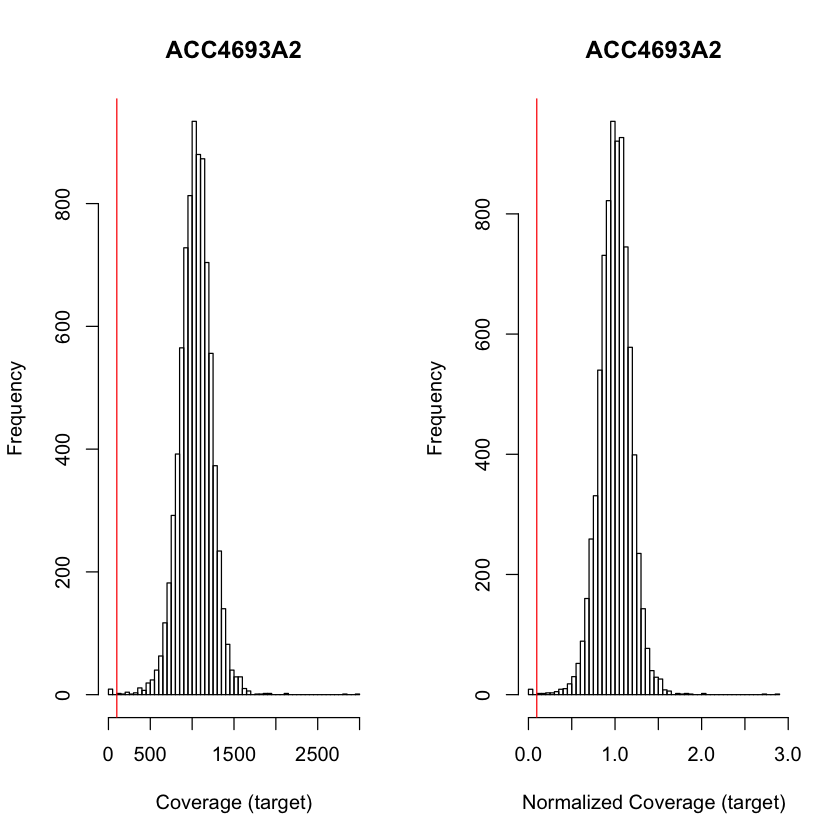

In [350]:
covSample = fread("notebook_data/ACC4693A2_ATCGATCG_L001-2_R.sorted.mrkdup.cov.bed")
#covSample = covSample[meanCoverage>0,]
par(mfrow = c(1,2))
hist(covSample$meanCoverage, breaks = 100, xlab = "Coverage (target)", main = "ACC4693A2")
abline(v=100,col="red")

hist(covSample$meanCoverage/mean(covSample$meanCoverage), breaks = 100,
     xlab = "Normalized Coverage (target)", main = "ACC4693A2")
abline(v=100/mean(covSample$meanCoverage),col="red")

#covSample = fread("notebook_data/ACC4693A2_ATCGATCG_L001-2_R.sorted.mrkdup.exon.cov.bed")
#covSample = covSample[meanCoverage>10,]
#hist(covSample$meanCoverage, breaks = 100)
#hist(covSample$meanCoverage/mean(covSample$meanCoverage), breaks = 100)

F3,chr,chromStart,chromEnd,F9,F3,F7,maxExonCovCnt,maxLength,readCnt,meanCov,numExonCov
ENST00000453576,1,133373,133566,KNOWN,ENST00000453576,336,1,336,416,167.78800,1
ENST00000442987,1,131024,134836,KNOWN,ENST00000442987,3812,1,3812,1754,44.15060,1
ENST00000440782,1,657471,659740,KNOWN,ENST00000440782,2455,2,2455,3704,156.19100,2
ENST00000440782,1,660097,660283,KNOWN,ENST00000440782,2455,2,2455,14,3.50538,2
ENST00000427998,1,1001209,1001836,KNOWN,ENST00000427998,977,1,977,814,82.01440,1
ENST00000394517,1,1001209,1001385,KNOWN,ENST00000394517,397,1,397,787,257.48900,1


[1] 52413    12

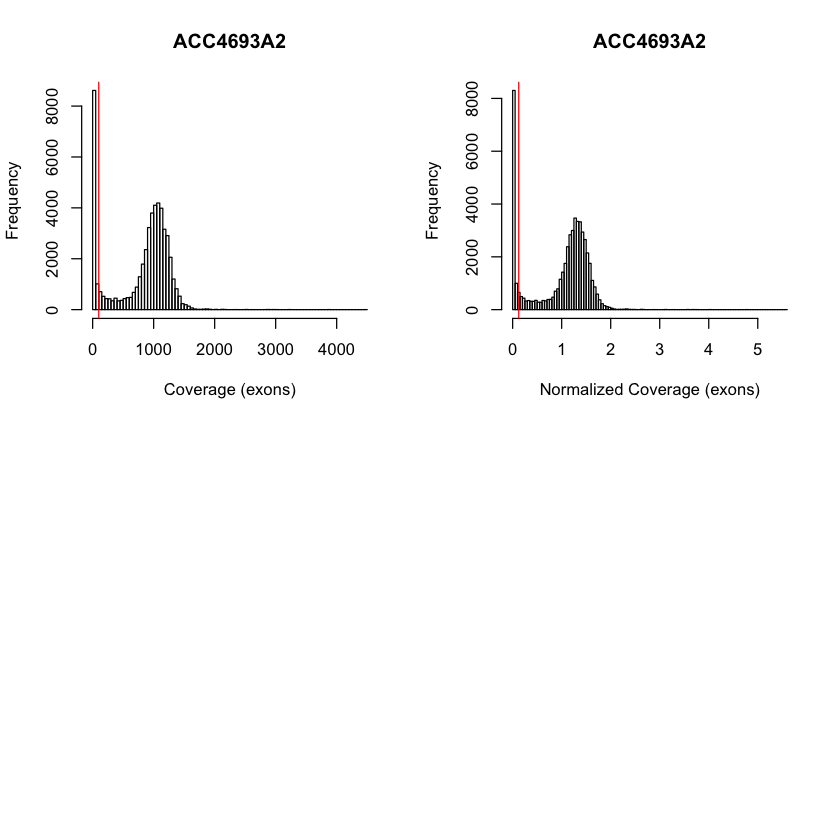

In [347]:
sampleCov = 1017
dt = unique(sample.coverage[,.(readCnt = readCount, meanCov = meanCoverage),
                            by = .(chr,chromStart,chromEnd,F10,F9,F7,F3)])
dt = dt[,.(chr, chromStart, chromEnd, F10, F9, F7, readCnt, meanCov, numExonCov=sum(readCnt!=0)),
        by=.(F3)]
dt = dt[readCnt>0 & numExonCov > 0,]
dt = dt[,.(chr, chromStart, chromEnd, F9, F3, F7, maxExonCovCnt=max(numExonCov), maxLength=max(F7),
           readCnt, meanCov, numExonCov), by=.(F3)]
dt = unique(dt[maxLength==F7 & readCnt>10])
head(dt)
dim(dt)
par(mfrow = c(2,2))

hist(dt$meanCov, breaks = 100 , xlab = "Coverage (exons)", main = "ACC4693A2")
abline(v=100,col="red")
hist(dt$meanCov/mean(dt$meanCov), breaks = 100,
     xlab = "Normalized Coverage (exons)", main = "ACC4693A2")
abline(v=100/mean(dt$meanCov),col="red")


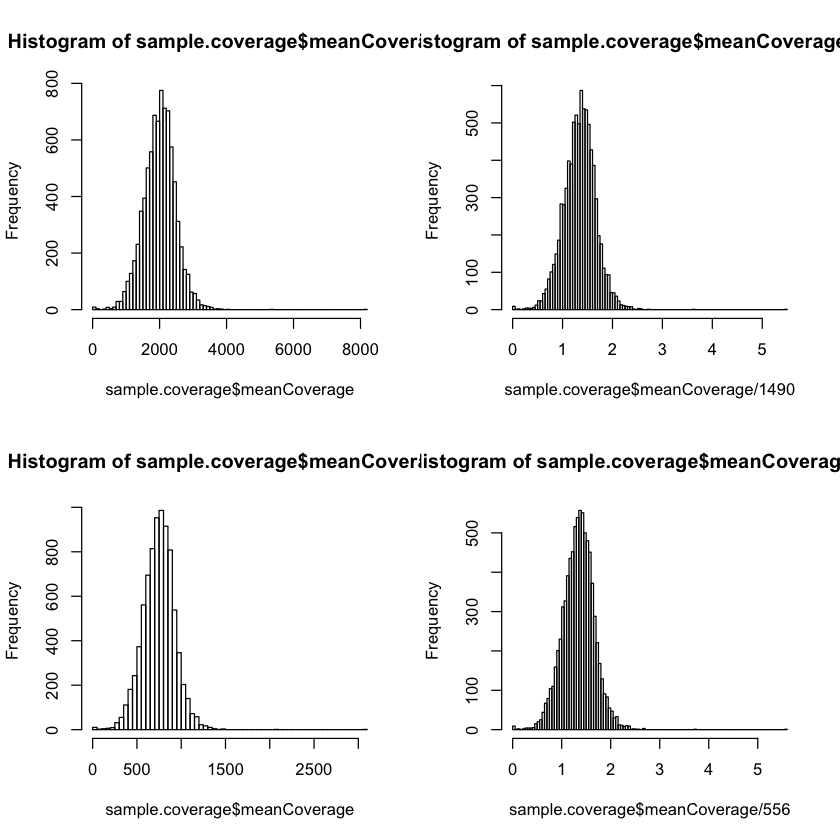

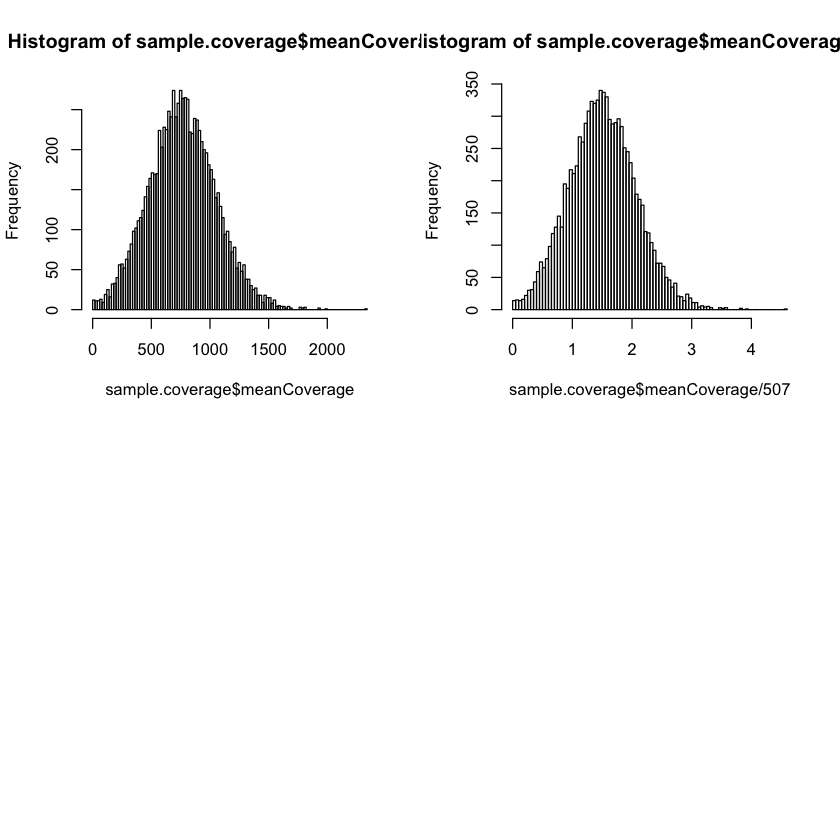

In [293]:
sample.coverage = read.table("notebook_data/ACC4551A4_fastq_R.Twist_CancerPanel_CG001.coverage", header = T)
par(mfrow = c(2,2))
hist(sample.coverage$meanCoverage, breaks = 100)

hist(sample.coverage$meanCoverage/1490, breaks = 100)

sample.coverage = read.table("notebook_data/ACC4551A4_CGGACAAC-TCCGGATT_L001_R.Twist_CancerPanel_CG001.coverage", header = T)
hist(sample.coverage$meanCoverage, breaks = 100)
hist(sample.coverage$meanCoverage/556, breaks = 100)

sample.coverage = read.table("notebook_data/2_170322_HHGC5BCXY_AL-P-00065154-T-03126604-TP201703161500-CB201703171630_L002.bedcoverage",
                             header = T)
hist(sample.coverage$meanCoverage, breaks = 100)
hist(sample.coverage$meanCoverage/507, breaks = 100)

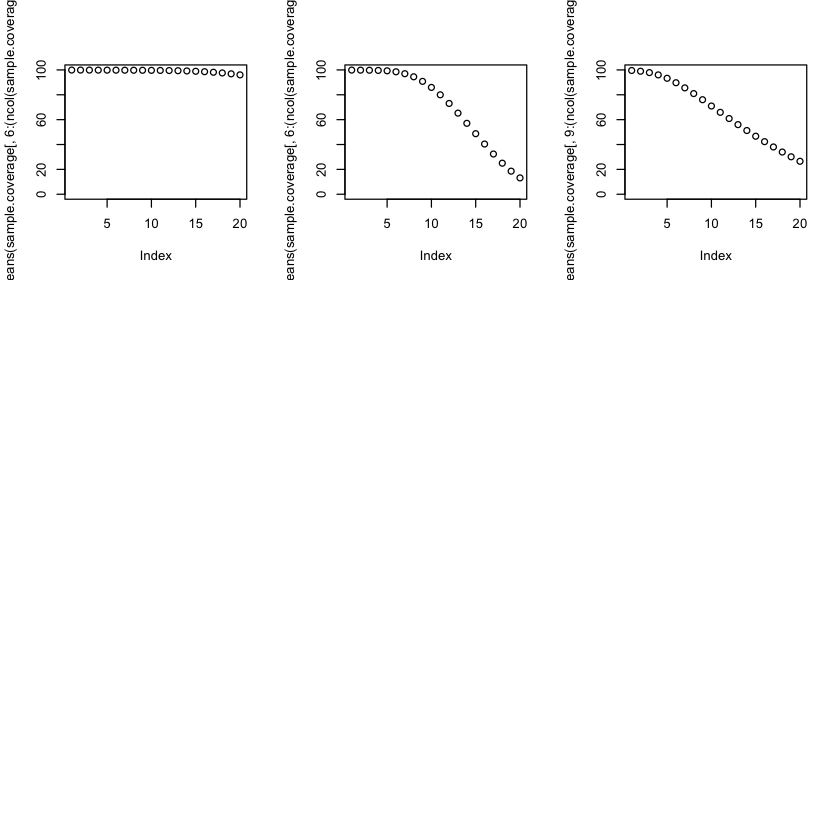

In [211]:
par(mfrow = c(3,3))
sample.coverage = read.table("notebook_data/ACC4551A4_fastq_R.Twist_CancerPanel_CG001.coverage", header = T)
plot(colMeans(sample.coverage[,6:(ncol(sample.coverage)-1)]), ylim = c(0,100))

sample.coverage = read.table("notebook_data/ACC4551A4_CGGACAAC-TCCGGATT_L001_R.Twist_CancerPanel_CG001.coverage", header = T)
plot(colMeans(sample.coverage[,6:(ncol(sample.coverage)-1)]), ylim = c(0,100))

sample.coverage = read.table("notebook_data/2_170322_HHGC5BCXY_AL-P-00065154-T-03126604-TP201703161500-CB201703171630_L002.bedcoverage", header = T)
plot(colMeans(sample.coverage[,9:(ncol(sample.coverage)-1)]), ylim = c(0,100))

In [50]:
27e6/1.5e6


[1] 18

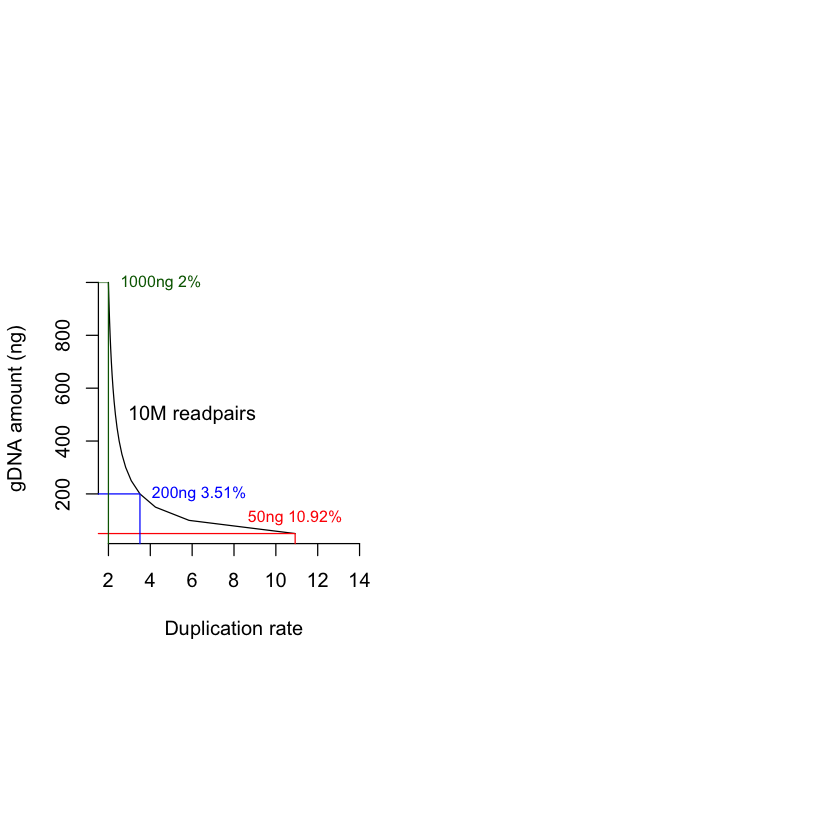

In [399]:
dup_rate = c()
c = 1
for (i in seq(from = 50, by = 50, to = 1000)) {
    gdna = i * 1e-9
    gpanel = 1.4e6

    unique_mol = (gdna * 0.5 / (660 * 250)) * 6e23

    gdna = gdna * 0.5

    #gdna * (400/250)

    #2000e-9/40e-9

    total_molecules = 500e-9 / (600 * 400) * 6e23

    total_molecules = (gpanel/3e9) * total_molecules

    total_unique = (gpanel/3e9) * unique_mol

    total_molecules = total_molecules * 0.5


    sample_chance = 1- (1-(1/total_unique))^total_molecules

    total_unique = total_unique * sample_chance

    total_read = 10e6

    dup_rate[c] = (1- (1-exp(-(total_read / total_unique )))/(total_read / total_unique)) * 100
    c = c + 1
}

par(mfrow = c(1,2), pty = "s")
plot(dup_rate, seq(from = 50, by = 50, to = 1000), bty = 'n', type = 'l', xlim = c(2,14),
     xlab = "Duplication rate", ylab = 'gDNA amount (ng)')

text(x=dup_rate[1], y = 50, col = "red",
     labels = paste0("50ng ", round(dup_rate[1], digits = 2), "%"), pos = 3, cex = 0.8)

text(x=dup_rate[4], y = 200, col = "blue",
     labels = paste0("200ng ", round(dup_rate[4], digits = 2), "%"), pos = 4, cex = 0.8)

text(x=dup_rate[c-1], y = 1000, col = "darkgreen",
     labels = paste0("1000ng ", round(dup_rate[c-1], digits = 2), "%"), pos = 4, cex = 0.8)

text(x=6, y=500, label="10M readpairs")

clip(x1 = 0, x2 = dup_rate[1], y1 = 0, y2 = 500)
abline(h = 50, col = "red")
clip(x1 = 0, x2 = 12, y1 = 0, y2 = 50)
abline(v = dup_rate[1], col = "red")

clip(x1 = 0, x2 = dup_rate[4], y1 = 0, y2 = 500)
abline(h = 200, col = "blue")
clip(x1 = 0, x2 = 12, y1 = 0, y2 = 200)
abline(v = dup_rate[4], col = "blue")


clip(x1 = 0, x2 = dup_rate[c-1], y1 = 0, y2 = 1000)
abline(h = 1000, col = "darkgreen")
clip(x1 = 0, x2 = 12, y1 = 0, y2 = 1000)
abline(v = dup_rate[c-1], col = "darkgreen")

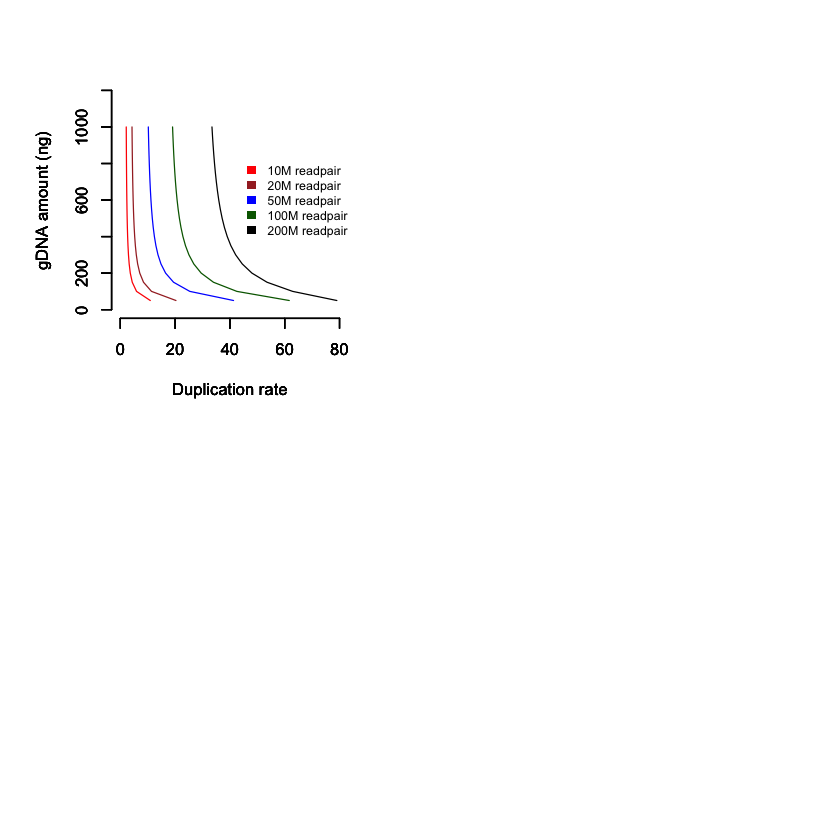

In [172]:
par(mfrow = c(2,2), pty = "s")
hybrid_amount = 500e-9
dna_weight_bp = 660
median_ins_size = 250
conversion_rate = 0.5
gpanel = 1.4e6
peak_frag_size = 400
capture_efficiency = 0.5
avogadro_num = 6e23
genome_size = 3e9
readC = c(10, 20, 50, 100, 200)
readCol = c("red", "brown", "blue", "darkgreen", "black")
s = 1
for (total_read in readC){
    dup_rate = c()
    #convert total read to M reads
    total_read = total_read * 1e6
    t = 1
    for (i in seq(from = 50, by = 50, to = 1000)) {
        
        gdna = i * 1e-9

        unique_mol = (gdna * conversion_rate / (dna_weight_bp * median_ins_size)) * avogadro_num

        total_molecules = hybrid_amount / (dna_weight_bp * peak_frag_size) * avogadro_num

        total_molecules = (gpanel/genome_size) * total_molecules

        total_unique = (gpanel/genome_size) * unique_mol

        total_molecules = total_molecules * capture_efficiency

        sample_chance = 1- (1-(1/total_unique))^total_molecules

        total_unique = total_unique * sample_chance

        dup_rate[t] = (1- (1-exp(-(total_read / total_unique )))/(total_read / total_unique)) * 100
        
        t = t + 1
    }

    plot(dup_rate, seq(from = 50, by = 50, to = 1000), bty = 'n', type = 'l',
         xlim = c(0, 80),
         ylim = c(0, 1200),
         col = readCol[s],
    #     xlim = c(round(min(dup_rate))-round(max(dup_rate))*0.25,round(max(dup_rate))+round(max(dup_rate))*0.25),
         xlab = "Duplication rate", ylab = 'gDNA amount (ng)')

    #text(x=dup_rate[1], y = 50, col = "red",
    #     labels = paste0("50ng ", round(dup_rate[1], digits = 2), "%"), pos = 3, cex = 0.8)

    #text(x=dup_rate[4], y = 200, col = "blue",
    #     labels = paste0("200ng ", round(dup_rate[4], digits = 2), "%"), pos = 4, cex = 0.8)

    #text(x=dup_rate[c-1], y = 1000, col = "darkgreen",
    #     labels = paste0("1000ng ", round(dup_rate[t-1], digits = 2), "%"), pos = 4, cex = 0.8)

    #text(x=round(mean(dup_rate)), y=1000,
    #     label=paste0(total_read, "M"), cex = 0.5, pos = 3)

    #clip(x1 = 0, x2 = dup_rate[1], y1 = 0, y2 = 1000)
    #abline(h = 50, col = "red")
    #clip(x1 = 0, x2 = 100, y1 = 0, y2 = 50)
    #abline(v = dup_rate[1], col = "red")
    #
    #clip(x1 = 0, x2 = dup_rate[4], y1 = 0, y2 = 1000)
    #abline(h = 200, col = "blue")
    #clip(x1 = 0, x2 = 100, y1 = 0, y2 = 200)
    #abline(v = dup_rate[4], col = "blue")
    #
    #clip(x1 = 0, x2 = dup_rate[t-1], y1 = 0, y2 = 1000)
    #abline(h = 1000, col = "darkgreen")
    #clip(x1 = 0, x2 = 100, y1 = 0, y2 = 1000)
    #abline(v = dup_rate[t-1], col = "darkgreen")
    
    par(new=T)
    s = s + 1
}

legend("right", legend = paste0(readC, "M readpair"), border = NA, fill = readCol, bty = "n", cex = 0.75)